# Model Training (Iterative Subset Runs)

This notebook trains a base code model using a **mixed dataset** containing:
- **FIM autocomplete** samples (`task=autocomplete_fim`)
- **comment/docstring → code** samples (`task=comment2code`)

In [1]:
# Imports
import sys
import json
import math
import random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple
import numpy as np
import torch

In [2]:
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers import Trainer
from tqdm.auto import tqdm

In [3]:
from peft import LoraConfig, TaskType, get_peft_model

In [4]:
# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

print("Project root added to path:", project_root)

Project root added to path: /storage/homefs/ai22t082/code_complete


In [5]:
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel,
)

In [6]:
# Import shared code modules
from src.config import MODELS_DIR, EVAL_DIR, ADAPTER_DIR, UNIFIED_DIR
from src.config import MODEL_NAME, MAX_LENGTH, SEED, NUM_ITERATIONS, SAMPLES_PER_ITERATION, EPOCHS_PER_ITERATION, BATCH_SIZE, VAL_MAX_SAMPLES
from src.config import LORA_TARGET_MODULES, LORA_R, LORA_ALPHA, LORA_DROPOUT
from src.data_processing import load_train_val_data, build_fim_text, build_c2c_prompt_completion, MixedDispatchCollator, Comment2CodeCollator, FimCollator
from src.evaluation import (
    evaluate_model_on_prompts,
    print_evaluation_summary,
    GENERIC_EVAL_PROMPTS,
    CDK_EVAL_PROMPTS
)

from src.training_utils import get_latest_checkpoint, save_iteration_indices, load_iteration_indices

In [7]:
print('torch:', torch.__version__)

torch: 2.7.0+cu128


In [8]:
# Device selection (CUDA > MPS > CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")


Using device: cuda


## Configuration
Tune these for quick iteration first (small subsets), then scale up.

In [9]:
# Paths
for dir_path in [MODELS_DIR, ADAPTER_DIR, EVAL_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Model configuration
# Tip: start with 1–3B locally, then try bigger if you have RAM/VRAM
print(f"Using model: {MODEL_NAME}")
print(f"Max sequence length: {MAX_LENGTH}")
print(f"Seed: {SEED}")

# Iterative training (subset runs)
print(f"Number of iterations: {NUM_ITERATIONS}")
print(f"Samples per iteration: {SAMPLES_PER_ITERATION}")

# Training
print(f"Epoch per iteration: {EPOCHS_PER_ITERATION}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Validation max samples: {VAL_MAX_SAMPLES}")

# Training hyperparameters
GRADIENT_ACCUMULATION_STEPS = 8
LEARNING_RATE = 2e-4
WARMUP_RATIO = 0.03
LOGGING_STEPS = 100
SAVE_STEPS = 100

print(f"Unified data: {UNIFIED_DIR}")
print(f"Adapter output: {ADAPTER_DIR}")
print(f"Model: {MODEL_NAME}")
print(f"Training: {NUM_ITERATIONS} iterations x {SAMPLES_PER_ITERATION} samples")

Using model: /storage/homefs/ai22t082/code_complete/models/base/Qwen/Qwen2.5-Coder-3B
Max sequence length: 1024
Seed: 42
Number of iterations: 10
Samples per iteration: 5000
Epoch per iteration: 1
Batch size: 1
Validation max samples: 2500
Unified data: /storage/homefs/ai22t082/code_complete/datasets/unified
Adapter output: /storage/homefs/ai22t082/code_complete/models/trained_adapter
Model: /storage/homefs/ai22t082/code_complete/models/base/Qwen/Qwen2.5-Coder-3B
Training: 10 iterations x 5000 samples


## Load datasets

In [10]:
print('Loading unified dataset...')
train_data, val_data = load_train_val_data(str(UNIFIED_DIR))

print(f"Loaded {len(train_data):,} training samples")
print(f"Loaded {len(val_data):,} validation samples")

fim_count = sum(1 for s in train_data if s.get('task') == 'autocomplete_fim')
c2c_count = sum(1 for s in train_data if s.get('task') == 'comment2code')
print(f"Train composition: FIM={fim_count:,}, comment2code={c2c_count:,}")

Loading unified dataset...
Loaded 57,754 training samples
Loaded 6,496 validation samples
Train composition: FIM=42,377, comment2code=15,377


## Load Model + Tokenizer

In [11]:
# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    use_fast=True,
    padding_side='right',
    local_files_only=True,
    fix_mistral_regex=True,
)

# Causal LM padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id


Loading tokenizer: /storage/homefs/ai22t082/code_complete/models/base/Qwen/Qwen2.5-Coder-3B


In [12]:
print('Loading base model...')
# dtype choice: fp16 on CUDA; float32 on CPU/MPS unless you know fp16 works for you
dtype = torch.float16 if device.type == 'cuda' else torch.float32
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype=dtype,
    local_files_only=True,
)
model.to(device)

print('Base model loaded')

Loading base model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Base model loaded


## Configure LoRA

In [13]:
print('Configuring LoRA...')
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias='none',
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


Configuring LoRA...
trainable params: 29,933,568 || all params: 3,115,872,256 || trainable%: 0.9607


## Mixed-task Data Collator (Correct Masking)

- `autocomplete_fim`: standard causal LM labels over full sequence
- `comment2code`: **mask prompt tokens** (`-100`) so the model learns only the code completion


In [14]:
collator = MixedDispatchCollator(
    c2c=Comment2CodeCollator(tokenizer=tokenizer, max_length=MAX_LENGTH),
    fim=FimCollator(tokenizer=tokenizer, max_length=MAX_LENGTH),
)
print('Collators ready')

Collators ready


## Validation helpers


In [34]:
def is_valid_sample(ex: Dict[str, Any]) -> bool:
    t = ex.get('task')

    if t == 'comment2code':
        # AND is correct: we need both prompt and completion
        return bool((ex.get('prompt') or '').strip() and (ex.get('completion') or '').strip())

    if t == 'autocomplete_fim':
        # accept structured or text
        return bool(
            (ex.get('text') or '').strip()
            or (ex.get('prefix') or '').strip()
            or (ex.get('suffix') or '').strip()
            or (ex.get('middle') or '').strip()
        )

    # fallback: require some text
    return bool((ex.get('text') or '').strip())

In [35]:
def is_valid_for_eval(ex: Dict[str, Any], tokenizer, max_length: int, min_completion_tokens: int = 8) -> bool:
    """Stricter than is_valid_sample; ensures evaluation loss is meaningful."""
    t = ex.get('task')

    if t == 'comment2code':
        prompt = (ex.get('prompt') or '').strip()
        completion = (ex.get('completion') or '').strip()
        if not (prompt and completion):
            return False

        prompt_ids = tokenizer(prompt, add_special_tokens=False).get('input_ids', [])
        if len(prompt_ids) >= max_length:
            return False

        comp_ids = tokenizer(completion, add_special_tokens=False).get('input_ids', [])
        if len(comp_ids) == 0:
            return False

        remaining = max_length - len(prompt_ids)
        # AND is correct: we need remaining space AND enough completion tokens
        return remaining >= min_completion_tokens

    if t == 'autocomplete_fim':
        text = (ex.get('text') or '').strip() or build_fim_text(ex).strip()
        if not text:
            return False
        ids = tokenizer(text, add_special_tokens=False).get('input_ids', [])
        return len(ids) > 0

    text = (ex.get('text') or '').strip()
    if not text:
        return False
    ids = tokenizer(text, add_special_tokens=False).get('input_ids', [])
    return len(ids) > 0

## Prepare Validation Dataset (fixed)

In [36]:
# Filter validation once (fixed val set)
val_data_eval = [ex for ex in val_data if is_valid_for_eval(ex, tokenizer, MAX_LENGTH)]
val_dataset = Dataset.from_list(val_data_eval[:VAL_MAX_SAMPLES] if VAL_MAX_SAMPLES else val_data_eval)
print('Val (evalable):', len(val_dataset))

from collections import Counter
print("Val task counts:", Counter([ex.get("task") for ex in val_dataset]))

Val (evalable): 5000
Val task counts: Counter({'autocomplete_fim': 3691, 'comment2code': 1309})


## Iterative Training Loop
Each iteration trains on a new random subset (deterministic seed) while keeping validation fixed.

In [37]:
class SafeTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        outputs = model(**inputs)
        loss = outputs.loss

        if loss is None:
            # Keep graph
            loss = outputs.logits.sum() * 0.0

        if not torch.isfinite(loss):
            loss = loss * 0.0

        return (loss, outputs) if return_outputs else loss

In [38]:
import inspect

ta_params = inspect.signature(TrainingArguments.__init__).parameters

iteration_metrics = []
best_eval_loss = float('inf')
best_iteration = None

ta_kwargs = dict(
    num_train_epochs=EPOCHS_PER_ITERATION,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=LEARNING_RATE,
    warmup_ratio=WARMUP_RATIO,
    logging_steps=LOGGING_STEPS,
    eval_steps=SAVE_STEPS,
    save_strategy='steps',
    save_steps=SAVE_STEPS,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    report_to='none',
    remove_unused_columns=False,
    dataloader_pin_memory=(device.type == 'cuda'),
    disable_tqdm=False,
    fp16=(device.type == 'cuda'),
    bf16=False,
    optim='adamw_torch',
)

if 'eval_strategy' in ta_params:
    ta_kwargs['eval_strategy'] = 'steps'
else:
    ta_kwargs['evaluation_strategy'] = 'steps'

In [ ]:
for iteration in range(NUM_ITERATIONS):
    print('' + '=' * 60)
    print(f'ITERATION {iteration + 1}/{NUM_ITERATIONS}')
    print('=' * 60)

    iter_seed = SEED + iteration
    out_dir = ADAPTER_DIR / f'iteration_{iteration+1:02d}'
    out_dir.mkdir(parents=True, exist_ok=True)

    # --- deterministic subset: load if exists, else create + save ---
    saved_idx = load_iteration_indices(out_dir)
    all_indices = list(range(len(train_data)))

    if saved_idx is not None:
        indices = saved_idx
        print(f'Loaded saved subset indices: {len(indices)} from {out_dir}')
    else:
        rng = random.Random(iter_seed)
        if SAMPLES_PER_ITERATION and SAMPLES_PER_ITERATION < len(all_indices):
            indices = rng.sample(all_indices, SAMPLES_PER_ITERATION)
        else:
            indices = all_indices
        save_iteration_indices(out_dir, indices)
        print(f'Saved subset indices: {len(indices)} (seed={iter_seed})')

    sampled_data = [train_data[i] for i in indices]
    sampled_data = [ex for ex in sampled_data if is_valid_sample(ex)]

    train_dataset = Dataset.from_list(sampled_data)

    print(f'Train samples this iteration: {len(train_dataset)}')

    # --- TrainingArguments (version-safe eval_strategy naming) ---
    ta_kwargs['output_dir']=str(out_dir)
    ta_kwargs['seed']=iter_seed

    training_args = TrainingArguments(**ta_kwargs)

    trainer = SafeTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=collator,
        processing_class=tokenizer,
    )

    resume_ckpt = get_latest_checkpoint(out_dir)
    if resume_ckpt:
        print(f'Resuming from checkpoint: {resume_ckpt}')

    print('Training...')
    train_result = trainer.train(resume_from_checkpoint=resume_ckpt)

    print('Evaluating...')
    eval_result = trainer.evaluate()

    metrics = {
        'iteration': iteration + 1,
        'train_loss': float(getattr(train_result, 'training_loss', float('nan'))),
        'eval_loss': float(eval_result.get('eval_loss', float('nan'))),
        'samples': int(len(train_dataset)),
        'seed': int(iter_seed),
        'resumed_from': resume_ckpt or None,
    }

    iteration_metrics.append(metrics)
    print('Iteration metrics:', metrics)

    # Save best adapter snapshot
    if metrics['eval_loss'] == metrics['eval_loss'] and metrics['eval_loss'] < best_eval_loss:  # NaN-safe
        best_eval_loss = metrics['eval_loss']
        best_iteration = iteration + 1
        best_path = ADAPTER_DIR / 'best_adapter'
        best_path.mkdir(parents=True, exist_ok=True)
        model.save_pretrained(str(best_path))
        tokenizer.save_pretrained(str(best_path))
        print(f"[BEST] Saved best adapter at iteration {best_iteration} (eval_loss={best_eval_loss:.4f})")

print(f"Best iteration: {best_iteration} (eval_loss={best_eval_loss:.4f})")

# Save metrics
with open(ADAPTER_DIR / 'iteration_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(iteration_metrics, f, indent=2)
print('Saved metrics to:', ADAPTER_DIR / 'iteration_metrics.json')

ITERATION 1/10
Saved subset indices: 10000 (seed=42)
Train samples this iteration: 10000
Training...


Step,Training Loss,Validation Loss
100,10.180600,1.248389
200,9.915500,1.237208
300,9.836900,1.222650
400,9.320200,1.211838
500,9.388100,1.205151
600,9.025400,1.202111
700,9.142000,1.195121
800,9.022100,1.189841
900,8.927100,1.184415
1000,8.785300,1.181445


Evaluating...


Iteration metrics: {'iteration': 1, 'train_loss': 9.247010375976563, 'eval_loss': 1.1784172058105469, 'samples': 10000, 'seed': 42, 'resumed_from': None}
[BEST] Saved best adapter at iteration 1 (eval_loss=1.1784)
ITERATION 2/10
Saved subset indices: 10000 (seed=43)
Train samples this iteration: 10000
Training...


Step,Training Loss,Validation Loss
100,8.213300,1.191688
200,8.329100,1.190214
300,8.102300,1.184746
400,7.955100,1.183531
500,8.138900,1.181114
600,7.461600,1.179190
700,7.855800,1.175046
800,7.704500,1.176832
900,7.269000,1.173983
1000,7.540400,1.168162


Evaluating...


Iteration metrics: {'iteration': 2, 'train_loss': 7.7701865234375, 'eval_loss': 1.168062448501587, 'samples': 10000, 'seed': 43, 'resumed_from': None}
[BEST] Saved best adapter at iteration 2 (eval_loss=1.1681)
ITERATION 3/10
Saved subset indices: 10000 (seed=44)
Train samples this iteration: 10000
Training...


Step,Training Loss,Validation Loss
100,7.807200,1.186977
200,7.808200,1.184372
300,7.849400,1.178792
400,7.593600,1.183273
500,7.465400,1.181077
600,7.518500,1.174796
700,7.415300,1.179835
800,7.318400,1.177396
900,7.232000,1.174889
1000,7.237400,1.177599


Evaluating...


Iteration metrics: {'iteration': 3, 'train_loss': 7.461419262695313, 'eval_loss': 1.1728912591934204, 'samples': 10000, 'seed': 44, 'resumed_from': None}
ITERATION 4/10
Saved subset indices: 10000 (seed=45)
Train samples this iteration: 10000
Training...


Step,Training Loss,Validation Loss
100,6.348800,1.180834
200,6.612900,1.207402
300,6.461300,1.199997
400,6.473600,1.193598
500,6.519300,1.198049
600,6.422200,1.192846
700,6.054300,1.194868
800,6.446100,1.184475
900,6.068700,1.201082
1000,6.256300,1.188697


Evaluating...


Iteration metrics: {'iteration': 4, 'train_loss': 6.3286884521484374, 'eval_loss': 1.1808339357376099, 'samples': 10000, 'seed': 45, 'resumed_from': None}
ITERATION 5/10
Saved subset indices: 10000 (seed=46)
Train samples this iteration: 10000
Training...


Step,Training Loss,Validation Loss
100,6.742000,1.192190
200,6.874200,1.190257
300,6.923700,1.202434
400,6.704200,1.193069
500,6.871000,1.187924
600,6.754400,1.190914
700,6.496900,1.195977
800,6.710000,1.203455
900,6.537700,1.196441
1000,6.412600,1.197471


Evaluating...


Iteration metrics: {'iteration': 5, 'train_loss': 6.638390307617187, 'eval_loss': 1.187923550605774, 'samples': 10000, 'seed': 46, 'resumed_from': None}
ITERATION 6/10
Saved subset indices: 10000 (seed=47)
Train samples this iteration: 10000
Training...


Step,Training Loss,Validation Loss
100,6.142700,1.212408
200,6.129800,1.207196
300,6.102500,1.211795
400,5.849900,1.213658
500,6.149400,1.220288
600,5.885500,1.210531
700,5.650700,1.204945
800,5.413900,1.217122
900,5.733900,1.210454
1000,5.866900,1.213341


Evaluating...


Iteration metrics: {'iteration': 6, 'train_loss': 5.82773623046875, 'eval_loss': 1.2049447298049927, 'samples': 10000, 'seed': 47, 'resumed_from': None}
ITERATION 7/10
Saved subset indices: 10000 (seed=48)
Train samples this iteration: 10000
Training...


Step,Training Loss,Validation Loss
100,6.100400,1.220978
200,6.222300,1.228021
300,6.115300,1.226723
400,5.996100,1.214828
500,6.115200,1.228197
600,5.962200,1.233525
700,5.983800,1.214828
800,5.946500,1.222587
900,5.683600,1.232863
1000,5.521200,1.238705


Evaluating...


Iteration metrics: {'iteration': 7, 'train_loss': 5.903461279296875, 'eval_loss': 1.2148276567459106, 'samples': 10000, 'seed': 48, 'resumed_from': None}
ITERATION 8/10
Saved subset indices: 10000 (seed=49)
Train samples this iteration: 10000
Training...


Step,Training Loss,Validation Loss
100,6.058400,1.228058
200,5.910700,1.240375
300,6.039000,1.244399
400,5.843000,1.249213
500,5.849500,1.241403
600,5.661100,1.232346
700,5.853200,1.238374
800,5.646100,1.239960
900,5.597900,1.243654
1000,5.472600,1.241134


Evaluating...


Iteration metrics: {'iteration': 8, 'train_loss': 5.719025952148438, 'eval_loss': 1.2280584573745728, 'samples': 10000, 'seed': 49, 'resumed_from': None}
ITERATION 9/10
Saved subset indices: 10000 (seed=50)
Train samples this iteration: 10000
Training...


Step,Training Loss,Validation Loss
100,5.818600,1.238352
200,6.076600,1.237761
300,5.719600,1.246853
400,5.586700,1.236638
500,5.589700,1.225363
600,5.603600,1.246607
700,5.625200,1.244742
800,5.649700,1.237731
900,5.492300,1.243564
1000,5.477400,1.253462


Evaluating...


Iteration metrics: {'iteration': 9, 'train_loss': 5.595542041015625, 'eval_loss': 1.225362777709961, 'samples': 10000, 'seed': 50, 'resumed_from': None}
ITERATION 10/10
Saved subset indices: 10000 (seed=51)
Train samples this iteration: 10000
Training...


Step,Training Loss,Validation Loss
100,4.792500,1.263085


In [39]:
for iteration in range(NUM_ITERATIONS):
    print('' + '=' * 60)
    print(f'ITERATION {iteration + 1}/{NUM_ITERATIONS}')
    print('=' * 60)

    iter_seed = SEED + iteration
    out_dir = ADAPTER_DIR / f'iteration_{iteration+1:02d}'
    out_dir.mkdir(parents=True, exist_ok=True)

    # --- deterministic subset: load if exists, else create + save ---
    saved_idx = load_iteration_indices(out_dir)
    all_indices = list(range(len(train_data)))

    if saved_idx is not None:
        indices = saved_idx
        print(f'Loaded saved subset indices: {len(indices)} from {out_dir}')
    else:
        rng = random.Random(iter_seed)
        if SAMPLES_PER_ITERATION and SAMPLES_PER_ITERATION < len(all_indices):
            indices = rng.sample(all_indices, SAMPLES_PER_ITERATION)
        else:
            indices = all_indices
        save_iteration_indices(out_dir, indices)
        print(f'Saved subset indices: {len(indices)} (seed={iter_seed})')

    sampled_data = [train_data[i] for i in indices]
    sampled_data = [ex for ex in sampled_data if is_valid_sample(ex)]

    train_dataset = Dataset.from_list(sampled_data)

    print(f'Train samples this iteration: {len(train_dataset)}')

    # --- TrainingArguments (version-safe eval_strategy naming) ---
    ta_kwargs['output_dir']=str(out_dir)
    ta_kwargs['seed']=iter_seed

    training_args = TrainingArguments(**ta_kwargs)

    trainer = SafeTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=collator,
        processing_class=tokenizer,
    )

    resume_ckpt = get_latest_checkpoint(out_dir)
    if resume_ckpt:
        print(f'Resuming from checkpoint: {resume_ckpt}')

    print('Training...')
    train_result = trainer.train(resume_from_checkpoint=resume_ckpt)

    print('Evaluating...')
    eval_result = trainer.evaluate()

    metrics = {
        'iteration': iteration + 1,
        'train_loss': float(getattr(train_result, 'training_loss', float('nan'))),
        'eval_loss': float(eval_result.get('eval_loss', float('nan'))),
        'samples': int(len(train_dataset)),
        'seed': int(iter_seed),
        'resumed_from': resume_ckpt or None,
    }

    iteration_metrics.append(metrics)
    print('Iteration metrics:', metrics)

    # Save best adapter snapshot
    if metrics['eval_loss'] == metrics['eval_loss'] and metrics['eval_loss'] < best_eval_loss:  # NaN-safe
        best_eval_loss = metrics['eval_loss']
        best_iteration = iteration + 1
        best_path = ADAPTER_DIR / 'best_adapter'
        best_path.mkdir(parents=True, exist_ok=True)
        model.save_pretrained(str(best_path))
        tokenizer.save_pretrained(str(best_path))
        print(f"[BEST] Saved best adapter at iteration {best_iteration} (eval_loss={best_eval_loss:.4f})")

print(f"Best iteration: {best_iteration} (eval_loss={best_eval_loss:.4f})")

# Save metrics
with open(ADAPTER_DIR / 'iteration_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(iteration_metrics, f, indent=2)
print('Saved metrics to:', ADAPTER_DIR / 'iteration_metrics.json')

ITERATION 1/10
Loaded saved subset indices: 10000 from /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_01
Train samples this iteration: 10000


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Resuming from checkpoint: /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_01/checkpoint-1250
Training...


Step,Training Loss,Validation Loss


Evaluating...


Iteration metrics: {'iteration': 1, 'train_loss': 0.0, 'eval_loss': 1.1784172058105469, 'samples': 10000, 'seed': 42, 'resumed_from': '/storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_01/checkpoint-1250'}
[BEST] Saved best adapter at iteration 1 (eval_loss=1.1784)
ITERATION 2/10
Loaded saved subset indices: 10000 from /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_02
Train samples this iteration: 10000
Resuming from checkpoint: /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_02/checkpoint-1250
Training...


Step,Training Loss,Validation Loss


Evaluating...


Iteration metrics: {'iteration': 2, 'train_loss': 0.0, 'eval_loss': 1.168062448501587, 'samples': 10000, 'seed': 43, 'resumed_from': '/storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_02/checkpoint-1250'}
[BEST] Saved best adapter at iteration 2 (eval_loss=1.1681)
ITERATION 3/10
Loaded saved subset indices: 10000 from /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_03
Train samples this iteration: 10000
Resuming from checkpoint: /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_03/checkpoint-1250
Training...


Step,Training Loss,Validation Loss


Evaluating...


Iteration metrics: {'iteration': 3, 'train_loss': 0.0, 'eval_loss': 1.1728912591934204, 'samples': 10000, 'seed': 44, 'resumed_from': '/storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_03/checkpoint-1250'}
ITERATION 4/10
Loaded saved subset indices: 10000 from /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_04
Train samples this iteration: 10000
Resuming from checkpoint: /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_04/checkpoint-1250
Training...


Step,Training Loss,Validation Loss


Evaluating...


Iteration metrics: {'iteration': 4, 'train_loss': 0.0, 'eval_loss': 1.1808339357376099, 'samples': 10000, 'seed': 45, 'resumed_from': '/storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_04/checkpoint-1250'}
ITERATION 5/10
Loaded saved subset indices: 10000 from /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_05
Train samples this iteration: 10000
Resuming from checkpoint: /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_05/checkpoint-1250
Training...


Step,Training Loss,Validation Loss


Evaluating...


Iteration metrics: {'iteration': 5, 'train_loss': 0.0, 'eval_loss': 1.187923550605774, 'samples': 10000, 'seed': 46, 'resumed_from': '/storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_05/checkpoint-1250'}
ITERATION 6/10
Loaded saved subset indices: 10000 from /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_06
Train samples this iteration: 10000
Resuming from checkpoint: /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_06/checkpoint-1250
Training...


Step,Training Loss,Validation Loss


Evaluating...


Iteration metrics: {'iteration': 6, 'train_loss': 0.0, 'eval_loss': 1.2049447298049927, 'samples': 10000, 'seed': 47, 'resumed_from': '/storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_06/checkpoint-1250'}
ITERATION 7/10
Loaded saved subset indices: 10000 from /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_07
Train samples this iteration: 10000
Resuming from checkpoint: /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_07/checkpoint-1250
Training...


Step,Training Loss,Validation Loss


Evaluating...


Iteration metrics: {'iteration': 7, 'train_loss': 0.0, 'eval_loss': 1.2148276567459106, 'samples': 10000, 'seed': 48, 'resumed_from': '/storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_07/checkpoint-1250'}
ITERATION 8/10
Loaded saved subset indices: 10000 from /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_08
Train samples this iteration: 10000
Resuming from checkpoint: /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_08/checkpoint-1250
Training...


Step,Training Loss,Validation Loss


Evaluating...


Iteration metrics: {'iteration': 8, 'train_loss': 0.0, 'eval_loss': 1.2280584573745728, 'samples': 10000, 'seed': 49, 'resumed_from': '/storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_08/checkpoint-1250'}
ITERATION 9/10
Loaded saved subset indices: 10000 from /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_09
Train samples this iteration: 10000
Resuming from checkpoint: /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_09/checkpoint-1250
Training...


Step,Training Loss,Validation Loss


Evaluating...


Iteration metrics: {'iteration': 9, 'train_loss': 0.0, 'eval_loss': 1.225362777709961, 'samples': 10000, 'seed': 50, 'resumed_from': '/storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_09/checkpoint-1250'}
ITERATION 10/10
Loaded saved subset indices: 10000 from /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_10
Train samples this iteration: 10000
Resuming from checkpoint: /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_10/checkpoint-1250
Training...


Step,Training Loss,Validation Loss


Evaluating...


Iteration metrics: {'iteration': 10, 'train_loss': 0.0, 'eval_loss': 1.2279995679855347, 'samples': 10000, 'seed': 51, 'resumed_from': '/storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_10/checkpoint-1250'}
Best iteration: 2 (eval_loss=1.1681)
Saved metrics to: /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_metrics.json


## Plot Training Curves

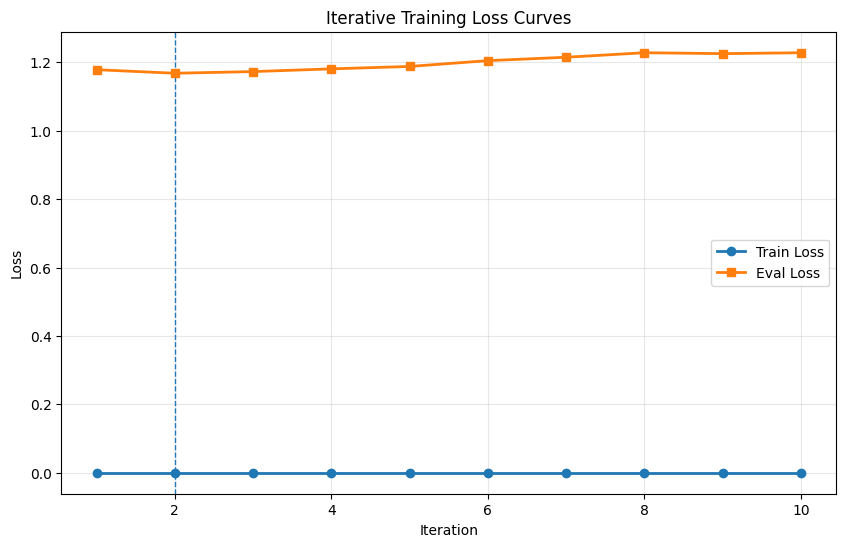

In [40]:
if iteration_metrics:
    iterations = [m.get("iteration") for m in iteration_metrics]
    train_losses = [m.get("train_loss") for m in iteration_metrics]
    eval_losses = [m.get("eval_loss") for m in iteration_metrics]

    def to_float_or_nan(x):
        try:
            x = float(x)
            return x if math.isfinite(x) else float("nan")
        except Exception:
            return float("nan")

    train_losses = [to_float_or_nan(x) for x in train_losses]
    eval_losses = [to_float_or_nan(x) for x in eval_losses]

    fig, ax = plt.subplots(figsize=(10, 6))

    if best_iteration is not None:
        ax.axvline(best_iteration, linestyle="--", linewidth=1)
    
    ax.plot(iterations, train_losses, marker="o", label="Train Loss", linewidth=2)
    ax.plot(iterations, eval_losses, marker="s", label="Eval Loss", linewidth=2)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Iterative Training Loss Curves")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()

## Load Best Adapter and Evaluate Prompts

In [ ]:
print('Loading best adapter for evaluation...')
best_adapter_path = ADAPTER_DIR / 'best_adapter'
dtype = torch.float16 if device.type == 'cuda' else torch.float32

base_eval_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, dtype=dtype)
base_eval_model.to(device)

eval_model = PeftModel.from_pretrained(base_eval_model, str(best_adapter_path))
eval_model.eval()
print("Loaded Best Model")

In [37]:

print('Evaluating on generic prompts...')
generic_results = evaluate_model_on_prompts(
    model=eval_model,
    tokenizer=tokenizer,
    prompts=GENERIC_EVAL_PROMPTS,
    device=str(device),
    max_tokens=120
)
for i, res in enumerate(generic_results):
    generic_results[i]['generated'] = res['generated'].split('<|fim_middle|>')[0]
print_evaluation_summary(generic_results)

print('\nEvaluating on CDK prompts...')
cdk_results = evaluate_model_on_prompts(
    model=eval_model,
    tokenizer=tokenizer,
    prompts=CDK_EVAL_PROMPTS,
    device=str(device),
    max_tokens=160
)
print_evaluation_summary(cdk_results)

all_results = generic_results + cdk_results
valid_count = sum(1 for r in all_results if r['syntax_valid'])

Evaluating on generic prompts...
EVALUATION SUMMARY
Total samples: 3
Syntax valid: 0/3 (0.0%)

Latency:
  Mean: 4287.8ms
  P50:  4289.5ms
  P95:  4290.0ms

Keyword match rate: 100.0%

Detailed Results:
✗ Factorial Function: 4290ms, keywords: 5/5
✗ List Filter: 4284ms, keywords: 5/5
✗ String Reversal: 4290ms, keywords: 4/4

Evaluating on CDK prompts...
EVALUATION SUMMARY
Total samples: 2
Syntax valid: 1/2 (50.0%)

Latency:
  Mean: 5726.2ms
  P50:  5728.5ms
  P95:  5728.5ms

Keyword match rate: 90.0%

Detailed Results:
✗ S3 Bucket with Encryption: 5724ms, keywords: 4/5
✓ Lambda Function: 5728ms, keywords: 5/5


In [40]:
MODEL_NAME

'/storage/homefs/ai22t082/code_complete/models/base/Qwen/Qwen2.5-Coder-3B'

In [ ]:
from textwrap import indent

for r in generic_results:
    print("=" * 90)
    print(f"TEST: {r.get('name')}")
    print(f"Latency: {r.get('latency_ms', 0):.0f} ms | Syntax valid: {r.get('syntax_valid')}"
          f" | Keyword match: {r.get('keyword_match_rate')}")
    print("-" * 90)
    print("PROMPT:\n" + indent(r.get("prompt", ""), "  "))
    print("-" * 90)
    print("GENERATED:\n" + indent(r.get("generated", ""), "  "))
    print()


In [43]:
for r in cdk_results:
    print("=" * 90)
    print(f"TEST: {r.get('name')}")
    print(f"Latency: {r.get('latency_ms', 0):.0f} ms | Syntax valid: {r.get('syntax_valid')}"
          f" | Keyword match: {r.get('keyword_match_rate')}")
    print("-" * 90)
    print("PROMPT:\n" + indent(r.get("prompt", ""), "  "))
    print("-" * 90)
    print("GENERATED:\n" + indent(r.get("generated", ""), "  "))
    print()

TEST: S3 Bucket with Encryption
Latency: 5707 ms | Syntax valid: False | Keyword match: 0.8
------------------------------------------------------------------------------------------
PROMPT:
  # Write Python code for the following docstring
  """
  Create an S3 bucket with:
  - Encryption enabled (KMS)
  - Versioning enabled
  - Block public access
  """

  # Code:

------------------------------------------------------------------------------------------
GENERATED:
  def create_bucket(bucket_name, region=None):
      """Create an S3 bucket with:
      - Encryption enabled (KMS)
      - Versioning enabled
      - Block public access
      """
      s3_client = boto3.client('s3')
      s3_client.create_bucket(
          Bucket=bucket_name,
          CreateBucketConfiguration={
              'LocationConstraint': region
          },
          ACL='private',
          ObjectLockEnabledForBucket=True,
      )
      s3_client.put_bucket_encryption(
          Bucket=bucket_name,
          Se

## Save Training Summary

In [44]:
results = {
    'model_name': MODEL_NAME,
    'training_type': 'iterative_subset_lora',
    'best_iteration': best_iteration,
    'best_eval_loss': best_eval_loss,
    'config': {
        'max_length': MAX_LENGTH,
        'seed': SEED,
        'num_iterations': NUM_ITERATIONS,
        'samples_per_iteration': SAMPLES_PER_ITERATION,
        'epochs_per_iteration': EPOCHS_PER_ITERATION,
        'val_max_samples': VAL_MAX_SAMPLES,
        'batch_size': BATCH_SIZE,
        'grad_accum': GRADIENT_ACCUMULATION_STEPS,
        'lr': LEARNING_RATE,
        'warmup_ratio': WARMUP_RATIO,
        'save_steps': SAVE_STEPS,
        'lora': {
            'r': LORA_R,
            'alpha': LORA_ALPHA,
            'dropout': LORA_DROPOUT,
            'target_modules': LORA_TARGET_MODULES,
        },
    },
    'iteration_metrics': iteration_metrics,
}

out_path = EVAL_DIR / 'training_summary_iterative.json'
out_path.parent.mkdir(parents=True, exist_ok=True)
with open(out_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2)

print(f"Saved training summary to: {out_path}")


Saved training summary to: /storage/homefs/ai22t082/code_complete/evaluation/training_summary_iterative.json


In [50]:
@dataclass
class EvaluationPrompt:
    """Standard evaluation prompt."""
    name: str
    prompt: str
    language: str = "python"
    expected_keywords: List[str] = None

GENERIC_EVAL_PROMPTS = [
    EvaluationPrompt(
        name="Factorial Function",
        prompt="""# Write Python code for the following docstring
\"\"\"
Calculate the factorial of a number using recursion.
Args:
    n: A non-negative integer
Returns:
    The factorial of n
\"\"\"

""",
        language="python",
    ),
    EvaluationPrompt(
        name="List Filter",
        prompt="""# Write Python code for the following docstring
\"\"\"
Filter a list to keep only even numbers.
Args:
    numbers: A list of integers
Returns:
    A list containing only even numbers
\"\"\"

""",
        language="python",
    ),
    EvaluationPrompt(
        name="String Reversal",
        prompt="""# Write Python code for the following docstring
\"\"\"
Reverse a string.
Args:
    text: The input string
Returns:
    The reversed string
\"\"\"

""",
        language="python",
    ),
]

In [51]:
evaluate_model_on_prompts(
    model=eval_model,
    tokenizer=tokenizer,
    prompts=GENERIC_EVAL_PROMPTS,
    device=str(device),
    max_tokens=120
)

[{'name': 'Factorial Function',
  'prompt': '# Write Python code for the following docstring\n"""\nCalculate the factorial of a number using recursion.\nArgs:\n    n: A non-negative integer\nReturns:\n    The factorial of n\n"""\n\n',
  'generated': 'def factorial(n):\n    """\n    Calculate the factorial of a number using recursion.\n    Args:\n        n: A non-negative integer\n    Returns:\n        The factorial of n\n    """\n    if n == 0:\n        return 1\n    else:\n        return n * factorial(n-1)<|fim_middle|>\n    """\n    if n == 0:\n        return 1\n    else:\n        return n * factorial(n-1)  # Recursive case\n    return 1  # Base case\n    return n * factorial(n-1)  # Recursive case\n    return',
  'latency_ms': 4287.887811660767,
  'syntax_valid': False,
  'syntax_error': 'SyntaxError: unterminated triple-quoted string literal (detected at line 20) (<unknown>, line 13)',
  'keywords_found': [],
  'keywords_expected': [],
  'keyword_match_rate': 0},
 {'name': 'List Fi

In [52]:
from src.evaluation import generate_code

# Benchmark with different prompt lengths
benchmark_prompts = [
    "def hello():",  # Short
    "def process_data(data):\n    # Process input\n    result = []",  # Medium
    """class DataProcessor:
    def __init__(self, config):
        self.config = config

    def process(self, data):
        # Complex processing logic
        for item in data:""",  # Long
]

print("Benchmarking inference latency...")
print("=" * 60)

latencies = []
num_runs = 5

for prompt in benchmark_prompts:
    for _ in range(num_runs):
        _, latency = generate_code(
            model=model,
            tokenizer=tokenizer,
            prompt=prompt,
            max_tokens=15,
            device=str(device)
        )
        latencies.append(latency)

# Calculate statistics
latencies_sorted = sorted(latencies)
p50 = latencies_sorted[len(latencies_sorted)//2]
p95 = latencies_sorted[int(len(latencies_sorted)*0.95)]

Benchmarking inference latency...


In [49]:
from src.data_processing import tokenizer_supports_fim
from src.evaluation import summarize_evaluation_results

fim_supported = tokenizer_supports_fim(tokenizer)

# Prepare baseline results
model_results = {
    "model_name": MODEL_NAME,
    "model_type": f"M1_{MODEL_NAME}",
    "fim_supported": fim_supported,
    "generic_evaluation": {
        "summary": summarize_evaluation_results(generic_results),
        "detailed_results": generic_results
    },
    "cdk_evaluation": {
        "summary": summarize_evaluation_results(cdk_results),
        "detailed_results": cdk_results
    },
    "latency_benchmark": {
        "mean_ms": float(np.mean(latencies)),
        "median_ms": float(p50),
        "p95_ms": float(p95),
        "min_ms": float(min(latencies)),
        "max_ms": float(max(latencies)),
        "std_dev_ms": float(np.std(latencies)),
        "num_samples": len(latencies),
        "p50_requirement_met": p50 <= 300,
        "p95_requirement_met": p95 <= 800
    },
    "overall_metrics": {
        "total_evaluations": len(all_results),
        "syntax_valid_count": valid_count,
        "syntax_validity_percent": 100 * valid_count / len(all_results)
    }
}

# Save to JSON
results_file = EVAL_DIR / "trained_model_results.json"
with open(results_file, 'w') as f:
    json.dump(baseline_results, f, indent=2)